# 1 - Multi-Modal LLM: PaliGemma

The PaliGemma model is a multi-modal large language model (MLLM) capable of processing various input modalities (image, audio, video) to generate text.

Notebooked based on:
- https://colab.research.google.com/drive/1gOhRCFyt9yIoasJkd4VoaHcIqJPdJnlg?usp=sharing#scrollTo=zchyD7YIsmi7

In [ ]:
!pip install -q -U accelerate bitsandbytes transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.1 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16)
model.to(device)

processor = PaliGemmaProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

## 1.1 - Model Architecture

The model architecture with its core components is summarized here:

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/multi-modal-llm.png)


- **Modality Encoder**:
Processes different input data types into a unified representation. For vision, it uses the SiglipVisionModel, which includes embeddings to convert images into patch embeddings, and an encoder with multiple layers of self-attention and MLP.

- **Modality Interface**:
Projects the encoded data into a format suitable for the language model using the PaliGemmaMultiModalProjector, a linear layer that converts encoded modalities to match the language model's input dimensions.

- **Large Language Model (LLM)**:
Generates text based on the unified representation. The GemmaForCausalLM language model includes an embedding layer for text tokens, multiple decoder layers with self-attention and MLP, and an LM head to output the final text predictions.


Vision Transformer

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/vision-transformer.png)



In [ ]:
print(model)

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_features=115

In [ ]:
inputs = processor(text="Describe the image", images=peacock_picture,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
print(inputs)

{'input_ids': tensor([[257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         25715

# 2 - Inference

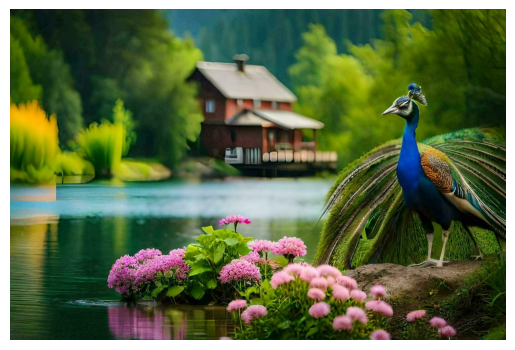

In [ ]:
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

def load_image(url):
  input_image = Image.open(requests.get(url, stream=True).raw)
  plt.imshow(input_image)
  plt.axis('off')  # Turn off axis numbers and ticks
  plt.show()
  return input_image

peacock_picture = load_image("https://static.vecteezy.com/system/resources/previews/032/257/185/non_2x/wallpapers-for-the-beautiful-peacock-wallpaper-ai-generated-free-photo.jpg")


In [ ]:
def query(image, prompt):
  inputs = processor(text=prompt, images=image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
  inputs = inputs.to(dtype=model.dtype)

  with torch.no_grad():
    output = model.generate(**inputs, max_length=496)

  return processor.decode(output[0], skip_special_tokens=True)

## 2.1 - Image description

In [ ]:
print(query(peacock_picture, "Describe the image"))

Describe the image
In this image we can see a peacock, flowers, plants, water, house and trees.


## 2.2 - Visual Q&A

In [ ]:
print(query(peacock_picture, "What color is the peacock?"))

What color is the peacock?
blue


In [ ]:
print(query(peacock_picture, "What is the peacock standing on?"))

What is the peacock standing on?
rock


In [ ]:
print(query(peacock_picture, "What color are the flowers?"))

What color are the flowers?
pink


## 2.3 - OCR

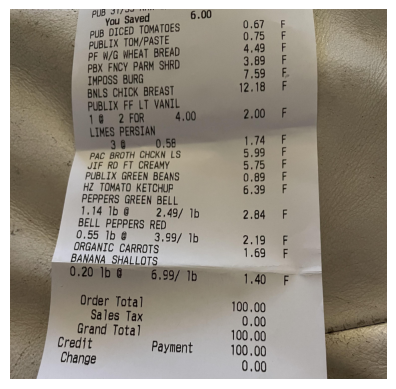

What is this?
receipt


In [ ]:
receipt = load_image("https://i.redd.it/sa4bzhkgewj81.jpg")

print(query(receipt, "What is this?"))

In [ ]:
print(query(receipt, "What did the customer buy?"))

What did the customer buy?
groceries


In [ ]:
print(query(receipt, "What is the total?"))

What is the total?
100.00


In [ ]:
print(query(receipt, "How many bananas did the customer buy?"))

How many bananas did the customer buy?
2


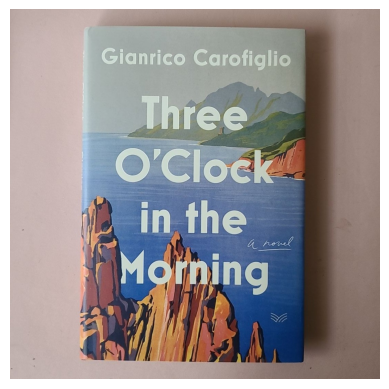

What is this?
book


In [ ]:
book = load_image("https://images.pangobooks.com/images/337e7e87-b26e-42d8-b4be-57a4825c39b2?quality=85&width=1200&crop=1%3A1")

print(query(book, "What is this?"))

In [ ]:
print(query(book, "Who is the author?"))

Who is the author?
gianrico carofiglio


In [ ]:
print(query(book, "What's the title?"))

What's the title?
three o'clock in the morning


## 2.4 - Object detection

In [ ]:
output = query(peacock_picture, "detect peacock")
print(output)

detect peacock
<loc0214><loc0627><loc0825><loc1022> peacock


In [ ]:
import re
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def display_bounding_box(pil_image, model_output):
    # Parse the location tokens
    loc_values = re.findall(r'<loc(\d+)>', model_output)
    loc_values = [int(val) for val in loc_values]

    # Convert normalized coordinates to image coordinates
    width, height = pil_image.size
    y_min, x_min, y_max, x_max = [
        int(loc_values[i] / 1024 * (height if i % 2 == 0 else width))
        for i in range(4)
    ]

    # Create a copy of the image to draw on
    draw_image = pil_image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Draw the bounding box
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(draw_image)
    plt.axis('off')
    plt.show()

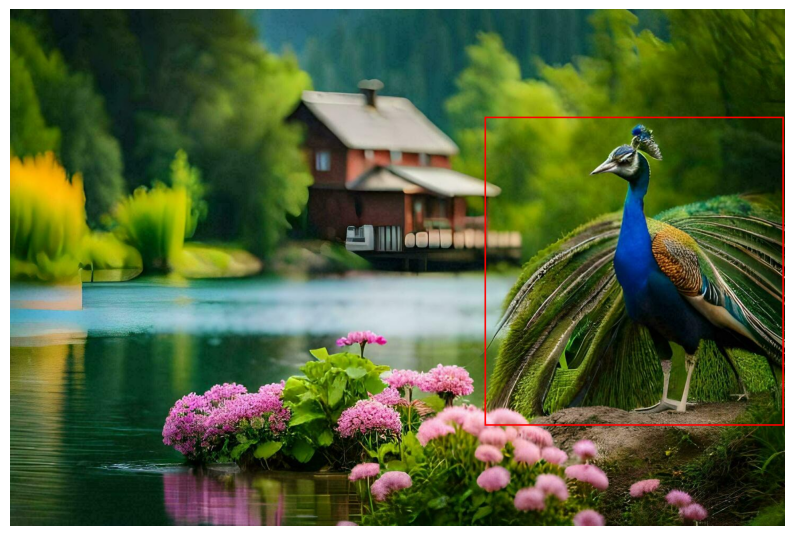

In [ ]:
display_bounding_box(peacock_picture, output)